In [1]:
import os
current_path = os.getcwd()
import numpy as np
from numpy import seterr
seterr(all='raise')
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm
import sys
sys.path.append(current_path)
sys.path.append(current_path+'/../../')
import myInput
import PACKAGE_MP_Linear as linear2d
import post_processing
import PACKAGE_MP_3DLinear as Linear_3D
import PACKAGE_MP_3DVertex as Vertex_3D
sys.path.append(current_path+'/../calculate_tangent/')

import importlib
importlib.reload(post_processing)
importlib.reload(Linear_3D)
importlib.reload(linear2d)


<module 'PACKAGE_MP_Linear' from '/home/lin.yang/projects/VECTOR/examples/GB_velocity/../../PACKAGE_MP_Linear.py'>

In [2]:

def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

## 2D

In [3]:
if __name__ == '__main__':
    # File name
    init_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_multiCoreCompare/IC/"
    data_file_folder = "/blue/michael.tonks/lin.yang/VECTOR_data/"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_fully/results/"
    # npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_wellEnergy/results/"
    case_name = "20k_fully"
    init_file_name = f"Case4.init"
    npy_file_name_aniso = f"p_aveE_fz_fully5d_20k_J1_f1.0_t1.0_refer_1_0_0_seed56689_kt0.66.npy"
    # npy_file_name_aniso = f"p_aveE_20000_Cos_delta0.0_J1_refer_1_0_0_seed56689_kt0.66.npy"
    
    # Initial data
    npy_file_aniso = np.load(npy_file_folder + npy_file_name_aniso)
    npy_file_aniso = npy_file_aniso.astype(int)
    print(f"The {case_name} data size is: {npy_file_aniso.shape}")
    print("READING DATA DONE")
    step_num, size_x, size_y, size_z = npy_file_aniso.shape
    
    data_miso_dict_file_name = f"GB_velocity_data/2D_miso_dict_data_MI_{case_name}.npz"
    miso_dict = np.load(data_file_folder+data_miso_dict_file_name,allow_pickle=True)["miso_dict"].item()
    print("miso_dict DATA DONE")
    

The 20k_fully data size is: (201, 2400, 2400, 1)
READING DATA DONE
miso_dict DATA DONE


In [4]:
    step_num=121
    grain_nums = 20000
    GB_infomation_dict_list = []
    inclination_matrix_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name = f"GB_velocity_data/2D_inclination_velocity_data_MI_{case_name}_step{time_step}.npz"
        data_inclination_file_name = f"GB_velocity_data/2D_matrix_inclination_data_MI_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name):
            npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
            GB_infomation_dict = npz_file["GB_infomation_dict"]
            GB_infomation_dict_list.append(GB_infomation_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            # get inclination
            if os.path.exists(data_file_folder + data_inclination_file_name):
                npz_file_inclination = np.load(data_file_folder + data_inclination_file_name)
                inclination_matrix = npz_file_inclination["inclination_matrix"]
                inclination_matrix_list.append(inclination_matrix)
            else:
                cores = 128
                loop_times = 5
                R = np.zeros((size_x,size_y,3))
                smoothing_class = linear2d.linear_class(size_x,size_y,grain_nums,cores,loop_times,current_microstructure[:,:,0],R,verification_system = False)
                smoothing_class.linear_main("inclination")
                P_ln = smoothing_class.get_P()
                inclination_matrix = P_ln[1:3,:]
                inclination_matrix_list.append(inclination_matrix)
                # save inclination information
                # np.savez(data_file_folder + data_inclination_file_name, inclination_matrix=inclination_matrix)
            print("Finish inclination calculation")
            
            # Get TJ and QJ information first
            TJ_infomation_dict = dict()
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: 
                        for m in range(len(neighboring_sites_list_unque)):
                            pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
                            if pair_id in TJ_infomation_dict:
                                tmp = TJ_infomation_dict[pair_id]
                                tmp.append([i,j,k])
                                TJ_infomation_dict[pair_id] = tmp
                            else: 
                                TJ_infomation_dict[pair_id] = [[i,j,k]]
            print("Finish TJ extraction")
            
            # Get the center of each GB
            GB_infomation_dict = dict()
            TJ_distance_max = 6 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # CONTINUE...    # remove the voxels around TJs and QJs
                    # check the GB voxels is close to TJ or not
                    break_point = 0
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GB_infomation_dict:
                        GB_infomation_dict[pair_id][6] += 1 # GB area
                    else:
                        GB_infomation = np.array([0,0,0,0,0.0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-inclination,i,j,k,inclination0,inclination1,GBnum,gid0,gid1
                        GB_infomation_dict[pair_id] = GB_infomation
                    if pair_id in TJ_infomation_dict:
                        for TJ_site in TJ_infomation_dict[pair_id]:
                            TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                            if TJ_distance < TJ_distance_max: 
                                break_point = 1
                                break
                    if break_point == 1: continue
                    # calculate or extract inclination
                    # if pair_id in GB_infomation_dict:
                    GB_infomation_dict[pair_id][0] += 1
                    if central_site == pair_id_pair[0]:
                        GB_infomation_dict[pair_id][1:6] += np.array([i,j,k,inclination_matrix[0,i,j],inclination_matrix[1,i,j]])
                    else: 
                        GB_infomation_dict[pair_id][1:6] += np.array([i,j,k,-inclination_matrix[0,i,j],-inclination_matrix[1,i,j]])
                    
            # get the correct location for each GB
            small_GB_list = []
            for key in GB_infomation_dict: 
                if GB_infomation_dict[key][0] == 0: 
                    small_GB_list.append(key) # get the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GB_infomation_dict.pop(small_GB_list[s_index]) # remove small GB
            for key in GB_infomation_dict: 
                GB_infomation_dict[key][1:4]=GB_infomation_dict[key][1:4]/GB_infomation_dict[key][0]
                GB_infomation_dict[key][4:6]=GB_infomation_dict[key][4:6]/np.linalg.norm(GB_infomation_dict[key][4:6])
            print(f"Current GBs len at {time_step} steps: {len(GB_infomation_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name, GB_infomation_dict=GB_infomation_dict)
            GB_infomation_dict_list.append(GB_infomation_dict)
            

  0%|          | 0/121 [00:00<?, ?it/s]

Finish inclination calculation
Finish TJ extraction


  1%|          | 1/121 [02:36<5:13:09, 156.58s/it]

Current GBs len at 0 steps: 22827
Finish inclination calculation
Finish TJ extraction


  2%|▏         | 2/121 [05:15<5:13:28, 158.05s/it]

Current GBs len at 1 steps: 18957
Finish inclination calculation
Finish TJ extraction


  2%|▏         | 3/121 [07:55<5:12:26, 158.87s/it]

Current GBs len at 2 steps: 16156
Finish inclination calculation
Finish TJ extraction


  3%|▎         | 4/121 [10:25<5:03:10, 155.47s/it]

Current GBs len at 3 steps: 13834
Finish inclination calculation
Finish TJ extraction


  4%|▍         | 5/121 [12:54<4:56:08, 153.17s/it]

Current GBs len at 4 steps: 11980
Finish inclination calculation
Finish TJ extraction


  5%|▍         | 6/121 [15:23<4:50:54, 151.78s/it]

Current GBs len at 5 steps: 10494
Finish inclination calculation
Finish TJ extraction


  6%|▌         | 7/121 [17:52<4:46:11, 150.62s/it]

Current GBs len at 6 steps: 9305
Finish inclination calculation
Finish TJ extraction


  7%|▋         | 8/121 [20:17<4:40:29, 148.93s/it]

Current GBs len at 7 steps: 8450
Finish inclination calculation
Finish TJ extraction


  7%|▋         | 9/121 [22:45<4:37:13, 148.51s/it]

Current GBs len at 8 steps: 7701
Finish inclination calculation
Finish TJ extraction


  8%|▊         | 10/121 [25:13<4:34:42, 148.49s/it]

Current GBs len at 9 steps: 7107
Finish inclination calculation
Finish TJ extraction


  9%|▉         | 11/121 [27:42<4:32:46, 148.79s/it]

Current GBs len at 10 steps: 6606
Finish inclination calculation
Finish TJ extraction


 10%|▉         | 12/121 [30:12<4:30:29, 148.90s/it]

Current GBs len at 11 steps: 6184
Finish inclination calculation
Finish TJ extraction


 11%|█         | 13/121 [32:39<4:27:02, 148.36s/it]

Current GBs len at 12 steps: 5777
Finish inclination calculation
Finish TJ extraction


 12%|█▏        | 14/121 [35:06<4:24:03, 148.07s/it]

Current GBs len at 13 steps: 5411
Finish inclination calculation
Finish TJ extraction


 12%|█▏        | 15/121 [37:34<4:21:30, 148.03s/it]

Current GBs len at 14 steps: 5112
Finish inclination calculation
Finish TJ extraction


 13%|█▎        | 16/121 [40:03<4:19:40, 148.39s/it]

Current GBs len at 15 steps: 4791
Finish inclination calculation
Finish TJ extraction


 14%|█▍        | 17/121 [42:32<4:17:31, 148.57s/it]

Current GBs len at 16 steps: 4564
Finish inclination calculation
Finish TJ extraction


 15%|█▍        | 18/121 [44:59<4:14:06, 148.02s/it]

Current GBs len at 17 steps: 4385
Finish inclination calculation
Finish TJ extraction


 16%|█▌        | 19/121 [47:25<4:10:41, 147.46s/it]

Current GBs len at 18 steps: 4154
Finish inclination calculation
Finish TJ extraction


 17%|█▋        | 20/121 [49:51<4:07:32, 147.05s/it]

Current GBs len at 19 steps: 3960
Finish inclination calculation
Finish TJ extraction


 17%|█▋        | 21/121 [52:19<4:05:38, 147.38s/it]

Current GBs len at 20 steps: 3813
Finish inclination calculation
Finish TJ extraction


 18%|█▊        | 22/121 [54:49<4:04:08, 147.96s/it]

Current GBs len at 21 steps: 3648
Finish inclination calculation
Finish TJ extraction


 19%|█▉        | 23/121 [57:19<4:03:01, 148.80s/it]

Current GBs len at 22 steps: 3511
Finish inclination calculation
Finish TJ extraction


 20%|█▉        | 24/121 [59:50<4:01:36, 149.45s/it]

Current GBs len at 23 steps: 3377
Finish inclination calculation
Finish TJ extraction


 21%|██        | 25/121 [1:02:18<3:58:10, 148.86s/it]

Current GBs len at 24 steps: 3281
Finish inclination calculation
Finish TJ extraction


 21%|██▏       | 26/121 [1:04:47<3:55:34, 148.79s/it]

Current GBs len at 25 steps: 3164
Finish inclination calculation
Finish TJ extraction


 22%|██▏       | 27/121 [1:07:16<3:53:27, 149.01s/it]

Current GBs len at 26 steps: 3067
Finish inclination calculation
Finish TJ extraction


 23%|██▎       | 28/121 [1:09:47<3:51:57, 149.65s/it]

Current GBs len at 27 steps: 2930
Finish inclination calculation
Finish TJ extraction


 24%|██▍       | 29/121 [1:12:17<3:49:31, 149.69s/it]

Current GBs len at 28 steps: 2840
Finish inclination calculation
Finish TJ extraction


 25%|██▍       | 30/121 [1:14:46<3:46:54, 149.61s/it]

Current GBs len at 29 steps: 2744
Finish inclination calculation
Finish TJ extraction


 26%|██▌       | 31/121 [1:17:17<3:44:46, 149.85s/it]

Current GBs len at 30 steps: 2675
Finish inclination calculation
Finish TJ extraction


 26%|██▋       | 32/121 [1:19:46<3:41:53, 149.59s/it]

Current GBs len at 31 steps: 2579
Finish inclination calculation
Finish TJ extraction


 27%|██▋       | 33/121 [1:22:16<3:39:33, 149.69s/it]

Current GBs len at 32 steps: 2511
Finish inclination calculation
Finish TJ extraction


 28%|██▊       | 34/121 [1:24:44<3:36:26, 149.27s/it]

Current GBs len at 33 steps: 2441
Finish inclination calculation
Finish TJ extraction


 29%|██▉       | 35/121 [1:27:13<3:33:40, 149.07s/it]

Current GBs len at 34 steps: 2378
Finish inclination calculation
Finish TJ extraction


 30%|██▉       | 36/121 [1:29:41<3:30:58, 148.93s/it]

Current GBs len at 35 steps: 2344
Finish inclination calculation
Finish TJ extraction


 31%|███       | 37/121 [1:32:11<3:29:02, 149.31s/it]

Current GBs len at 36 steps: 2320
Finish inclination calculation
Finish TJ extraction


 31%|███▏      | 38/121 [1:34:43<3:27:30, 150.00s/it]

Current GBs len at 37 steps: 2254
Finish inclination calculation
Finish TJ extraction


 32%|███▏      | 39/121 [1:37:14<3:25:15, 150.19s/it]

Current GBs len at 38 steps: 2193
Finish inclination calculation
Finish TJ extraction


 33%|███▎      | 40/121 [1:39:47<3:23:56, 151.07s/it]

Current GBs len at 39 steps: 2151
Finish inclination calculation
Finish TJ extraction


 34%|███▍      | 41/121 [1:42:19<3:21:41, 151.26s/it]

Current GBs len at 40 steps: 2075
Finish inclination calculation
Finish TJ extraction


 35%|███▍      | 42/121 [1:44:51<3:19:32, 151.55s/it]

Current GBs len at 41 steps: 2032
Finish inclination calculation
Finish TJ extraction


 36%|███▌      | 43/121 [1:47:24<3:17:35, 151.99s/it]

Current GBs len at 42 steps: 1983
Finish inclination calculation
Finish TJ extraction


 36%|███▋      | 44/121 [1:49:58<3:15:49, 152.59s/it]

Current GBs len at 43 steps: 1928
Finish inclination calculation
Finish TJ extraction


 37%|███▋      | 45/121 [1:52:32<3:13:48, 153.00s/it]

Current GBs len at 44 steps: 1908
Finish inclination calculation
Finish TJ extraction


 38%|███▊      | 46/121 [1:55:03<3:10:46, 152.62s/it]

Current GBs len at 45 steps: 1883
Finish inclination calculation
Finish TJ extraction


 39%|███▉      | 47/121 [1:57:38<3:09:01, 153.26s/it]

Current GBs len at 46 steps: 1852
Finish inclination calculation
Finish TJ extraction


 40%|███▉      | 48/121 [2:00:14<3:07:12, 153.87s/it]

Current GBs len at 47 steps: 1813
Finish inclination calculation
Finish TJ extraction


 40%|████      | 49/121 [2:02:48<3:04:45, 153.96s/it]

Current GBs len at 48 steps: 1768
Finish inclination calculation
Finish TJ extraction


 41%|████▏     | 50/121 [2:05:22<3:02:10, 153.95s/it]

Current GBs len at 49 steps: 1737
Finish inclination calculation
Finish TJ extraction


 42%|████▏     | 51/121 [2:07:56<2:59:35, 153.94s/it]

Current GBs len at 50 steps: 1700
Finish inclination calculation
Finish TJ extraction


 43%|████▎     | 52/121 [2:10:29<2:56:50, 153.77s/it]

Current GBs len at 51 steps: 1672
Finish inclination calculation
Finish TJ extraction


 44%|████▍     | 53/121 [2:13:04<2:54:36, 154.07s/it]

Current GBs len at 52 steps: 1653
Finish inclination calculation
Finish TJ extraction


 45%|████▍     | 54/121 [2:15:38<2:52:16, 154.28s/it]

Current GBs len at 53 steps: 1629
Finish inclination calculation
Finish TJ extraction


 45%|████▌     | 55/121 [2:18:14<2:50:13, 154.75s/it]

Current GBs len at 54 steps: 1595
Finish inclination calculation
Finish TJ extraction


 46%|████▋     | 56/121 [2:20:52<2:48:35, 155.62s/it]

Current GBs len at 55 steps: 1566
Finish inclination calculation
Finish TJ extraction


 47%|████▋     | 57/121 [2:23:28<2:46:10, 155.79s/it]

Current GBs len at 56 steps: 1542
Finish inclination calculation
Finish TJ extraction


 48%|████▊     | 58/121 [2:26:04<2:43:33, 155.78s/it]

Current GBs len at 57 steps: 1512
Finish inclination calculation
Finish TJ extraction


 49%|████▉     | 59/121 [2:28:40<2:41:13, 156.02s/it]

Current GBs len at 58 steps: 1495
Finish inclination calculation
Finish TJ extraction


 50%|████▉     | 60/121 [2:31:17<2:38:51, 156.26s/it]

Current GBs len at 59 steps: 1480
Finish inclination calculation
Finish TJ extraction


 50%|█████     | 61/121 [2:33:56<2:37:08, 157.14s/it]

Current GBs len at 60 steps: 1447
Finish inclination calculation
Finish TJ extraction


 51%|█████     | 62/121 [2:36:36<2:35:15, 157.88s/it]

Current GBs len at 61 steps: 1429
Finish inclination calculation
Finish TJ extraction


 52%|█████▏    | 63/121 [2:39:15<2:32:58, 158.25s/it]

Current GBs len at 62 steps: 1396
Finish inclination calculation
Finish TJ extraction


 53%|█████▎    | 64/121 [2:41:57<2:31:18, 159.27s/it]

Current GBs len at 63 steps: 1381
Finish inclination calculation
Finish TJ extraction


 54%|█████▎    | 65/121 [2:44:40<2:29:41, 160.38s/it]

Current GBs len at 64 steps: 1367
Finish inclination calculation
Finish TJ extraction


 55%|█████▍    | 66/121 [2:47:21<2:27:19, 160.72s/it]

Current GBs len at 65 steps: 1356
Finish inclination calculation
Finish TJ extraction


 55%|█████▌    | 67/121 [2:50:06<2:25:35, 161.77s/it]

Current GBs len at 66 steps: 1333
Finish inclination calculation
Finish TJ extraction


 56%|█████▌    | 68/121 [2:52:49<2:23:19, 162.26s/it]

Current GBs len at 67 steps: 1318
Finish inclination calculation
Finish TJ extraction


 57%|█████▋    | 69/121 [2:55:33<2:21:03, 162.75s/it]

Current GBs len at 68 steps: 1300
Finish inclination calculation
Finish TJ extraction


 58%|█████▊    | 70/121 [2:58:17<2:18:48, 163.31s/it]

Current GBs len at 69 steps: 1269
Finish inclination calculation
Finish TJ extraction


 59%|█████▊    | 71/121 [3:01:02<2:16:21, 163.63s/it]

Current GBs len at 70 steps: 1251
Finish inclination calculation
Finish TJ extraction


 60%|█████▉    | 72/121 [3:03:47<2:13:54, 163.97s/it]

Current GBs len at 71 steps: 1247
Finish inclination calculation
Finish TJ extraction


 60%|██████    | 73/121 [3:06:33<2:11:39, 164.58s/it]

Current GBs len at 72 steps: 1221
Finish inclination calculation
Finish TJ extraction


 61%|██████    | 74/121 [3:09:20<2:09:36, 165.47s/it]

Current GBs len at 73 steps: 1205
Finish inclination calculation
Finish TJ extraction


 62%|██████▏   | 75/121 [3:12:06<2:07:00, 165.67s/it]

Current GBs len at 74 steps: 1187
Finish inclination calculation
Finish TJ extraction


 63%|██████▎   | 76/121 [3:14:50<2:03:47, 165.05s/it]

Current GBs len at 75 steps: 1161
Finish inclination calculation
Finish TJ extraction


 64%|██████▎   | 77/121 [3:17:36<2:01:13, 165.30s/it]

Current GBs len at 76 steps: 1137
Finish inclination calculation
Finish TJ extraction


 64%|██████▍   | 78/121 [3:20:23<1:58:58, 166.02s/it]

Current GBs len at 77 steps: 1114
Finish inclination calculation
Finish TJ extraction


 65%|██████▌   | 79/121 [3:23:12<1:56:44, 166.77s/it]

Current GBs len at 78 steps: 1097
Finish inclination calculation
Finish TJ extraction


 66%|██████▌   | 80/121 [3:26:01<1:54:25, 167.44s/it]

Current GBs len at 79 steps: 1084
Finish inclination calculation
Finish TJ extraction


 67%|██████▋   | 81/121 [3:28:48<1:51:36, 167.40s/it]

Current GBs len at 80 steps: 1079
Finish inclination calculation
Finish TJ extraction


 68%|██████▊   | 82/121 [3:31:38<1:49:14, 168.07s/it]

Current GBs len at 81 steps: 1062
Finish inclination calculation
Finish TJ extraction


 69%|██████▊   | 83/121 [3:34:26<1:46:24, 168.02s/it]

Current GBs len at 82 steps: 1054
Finish inclination calculation
Finish TJ extraction


 69%|██████▉   | 84/121 [3:37:16<1:43:56, 168.54s/it]

Current GBs len at 83 steps: 1032
Finish inclination calculation
Finish TJ extraction


 70%|███████   | 85/121 [3:40:05<1:41:14, 168.73s/it]

Current GBs len at 84 steps: 1028
Finish inclination calculation
Finish TJ extraction


 71%|███████   | 86/121 [3:42:56<1:38:50, 169.45s/it]

Current GBs len at 85 steps: 1020
Finish inclination calculation
Finish TJ extraction


 72%|███████▏  | 87/121 [3:45:44<1:35:48, 169.08s/it]

Current GBs len at 86 steps: 1009
Finish inclination calculation
Finish TJ extraction


 73%|███████▎  | 88/121 [3:48:33<1:32:59, 169.07s/it]

Current GBs len at 87 steps: 995
Finish inclination calculation
Finish TJ extraction


 74%|███████▎  | 89/121 [3:51:23<1:30:17, 169.28s/it]

Current GBs len at 88 steps: 986
Finish inclination calculation
Finish TJ extraction


 74%|███████▍  | 90/121 [3:54:14<1:27:47, 169.91s/it]

Current GBs len at 89 steps: 980
Finish inclination calculation
Finish TJ extraction


 75%|███████▌  | 91/121 [3:57:05<1:25:06, 170.23s/it]

Current GBs len at 90 steps: 969
Finish inclination calculation
Finish TJ extraction


 76%|███████▌  | 92/121 [3:59:59<1:22:43, 171.14s/it]

Current GBs len at 91 steps: 966
Finish inclination calculation
Finish TJ extraction


 77%|███████▋  | 93/121 [4:02:52<1:20:14, 171.95s/it]

Current GBs len at 92 steps: 950
Finish inclination calculation
Finish TJ extraction


 78%|███████▊  | 94/121 [4:05:46<1:17:39, 172.58s/it]

Current GBs len at 93 steps: 934
Finish inclination calculation
Finish TJ extraction


 79%|███████▊  | 95/121 [4:08:40<1:14:56, 172.95s/it]

Current GBs len at 94 steps: 933
Finish inclination calculation
Finish TJ extraction


 79%|███████▉  | 96/121 [4:11:35<1:12:16, 173.46s/it]

Current GBs len at 95 steps: 919
Finish inclination calculation
Finish TJ extraction


 80%|████████  | 97/121 [4:14:31<1:09:40, 174.20s/it]

Current GBs len at 96 steps: 895
Finish inclination calculation
Finish TJ extraction


 81%|████████  | 98/121 [4:17:28<1:07:09, 175.21s/it]

Current GBs len at 97 steps: 898
Finish inclination calculation
Finish TJ extraction


 82%|████████▏ | 99/121 [4:20:25<1:04:22, 175.59s/it]

Current GBs len at 98 steps: 879
Finish inclination calculation
Finish TJ extraction


 83%|████████▎ | 100/121 [4:23:19<1:01:19, 175.20s/it]

Current GBs len at 99 steps: 874
Finish inclination calculation
Finish TJ extraction


 83%|████████▎ | 101/121 [4:26:13<58:12, 174.64s/it]  

Current GBs len at 100 steps: 869
Finish inclination calculation
Finish TJ extraction


 84%|████████▍ | 102/121 [4:29:06<55:12, 174.32s/it]

Current GBs len at 101 steps: 855
Finish inclination calculation
Finish TJ extraction


 85%|████████▌ | 103/121 [4:32:02<52:25, 174.73s/it]

Current GBs len at 102 steps: 843
Finish inclination calculation
Finish TJ extraction


 86%|████████▌ | 104/121 [4:34:57<49:33, 174.89s/it]

Current GBs len at 103 steps: 835
Finish inclination calculation
Finish TJ extraction


 87%|████████▋ | 105/121 [4:37:53<46:44, 175.31s/it]

Current GBs len at 104 steps: 837
Finish inclination calculation
Finish TJ extraction


 88%|████████▊ | 106/121 [4:40:49<43:52, 175.47s/it]

Current GBs len at 105 steps: 829
Finish inclination calculation
Finish TJ extraction


 88%|████████▊ | 107/121 [4:43:46<41:02, 175.87s/it]

Current GBs len at 106 steps: 817
Finish inclination calculation
Finish TJ extraction


 89%|████████▉ | 108/121 [4:46:45<38:18, 176.82s/it]

Current GBs len at 107 steps: 815
Finish inclination calculation
Finish TJ extraction


 90%|█████████ | 109/121 [4:49:43<35:27, 177.32s/it]

Current GBs len at 108 steps: 815
Finish inclination calculation
Finish TJ extraction


 91%|█████████ | 110/121 [4:52:40<32:28, 177.14s/it]

Current GBs len at 109 steps: 806
Finish inclination calculation
Finish TJ extraction


 92%|█████████▏| 111/121 [4:55:40<29:38, 177.82s/it]

Current GBs len at 110 steps: 798
Finish inclination calculation
Finish TJ extraction


 93%|█████████▎| 112/121 [4:58:40<26:47, 178.59s/it]

Current GBs len at 111 steps: 793
Finish inclination calculation
Finish TJ extraction


 93%|█████████▎| 113/121 [5:01:40<23:52, 179.12s/it]

Current GBs len at 112 steps: 783
Finish inclination calculation
Finish TJ extraction


 94%|█████████▍| 114/121 [5:04:42<20:58, 179.77s/it]

Current GBs len at 113 steps: 781
Finish inclination calculation
Finish TJ extraction


 95%|█████████▌| 115/121 [5:07:44<18:02, 180.41s/it]

Current GBs len at 114 steps: 780
Finish inclination calculation
Finish TJ extraction


 96%|█████████▌| 116/121 [5:10:44<15:02, 180.43s/it]

Current GBs len at 115 steps: 769
Finish inclination calculation
Finish TJ extraction


 97%|█████████▋| 117/121 [5:13:45<12:01, 180.47s/it]

Current GBs len at 116 steps: 762
Finish inclination calculation
Finish TJ extraction


 98%|█████████▊| 118/121 [5:16:44<09:00, 180.27s/it]

Current GBs len at 117 steps: 760
Finish inclination calculation
Finish TJ extraction


 98%|█████████▊| 119/121 [5:19:47<06:01, 180.94s/it]

Current GBs len at 118 steps: 744
Finish inclination calculation
Finish TJ extraction


 99%|█████████▉| 120/121 [5:22:50<03:01, 181.58s/it]

Current GBs len at 119 steps: 735
Finish inclination calculation
Finish TJ extraction


100%|██████████| 121/121 [5:25:53<00:00, 161.60s/it]

Current GBs len at 120 steps: 736


In [5]:
    time_interval = 2
    GB_list_velocity_list = []
    GB_list_inclination_list = []
    for time_step in range(step_num):
        if time_step+1 >= step_num: continue
        GB_list_velocity_list_tmp = []
        GB_list_inclination_list_tmp = []
        for key in tqdm(GB_infomation_dict_list[time_step]):
            if GB_infomation_dict_list[time_step+1].get(key) is None: continue
            # Calculate volumn change
            pair_id_pair = GB_infomation_dict_list[time_step][key][7:9]
            growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair[0])*(npy_file_aniso[time_step+1]==pair_id_pair[1])
            growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair[1])*(npy_file_aniso[time_step+1]==pair_id_pair[0])
            dV = abs(np.sum(growth_direction1)-np.sum(growth_direction2))
            # Calculate velocity
            velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key][6]/2)
            GB_list_velocity_list_tmp.append(velocity)
            
            # Get inclination
            DX, DY = GB_infomation_dict_list[time_step][key][4:6]
            vec_len = np.sqrt(DX**2+DY**2)
            if vec_len==0: dx, dy = 0, 0
            else: dx, dy = -DX/vec_len, DY/vec_len # the process just repeated get_grad(P,i,j) in myInput.py 
            dz = 0
            dy = -dy # Update the issue in VECTOR
            inclination = np.array([dx,dy,dz])
            # Get misorientation
            misorientation_axis = miso_dict[key][1:]
            # rotate misorientation axis to z axis, and incliantion to final vector
            z_axis = np.array([0,0,1])
            rotation_matrix_m_axis_to_z_axis = rotation_matrix_from_vectors(misorientation_axis, z_axis)
            incliantion_refer_m_axis = rotation_matrix_m_axis_to_z_axis.dot(inclination)
            # Get polar and azimuth dsitribution
            i_polar_angle = math.acos(round(incliantion_refer_m_axis[2],3))
            i_azimuth_angle = math.atan2(incliantion_refer_m_axis[1], incliantion_refer_m_axis[0]) + np.pi
            # Add the two angles here
            GB_list_inclination_list_tmp.append(np.array([i_polar_angle,i_azimuth_angle]))
            
        GB_list_velocity_list.append(GB_list_velocity_list_tmp)
        GB_list_inclination_list.append(GB_list_inclination_list_tmp)
            

100%|██████████| 735/735 [00:18<00:00, 39.82it/s]


<Figure size 432x288 with 0 Axes>

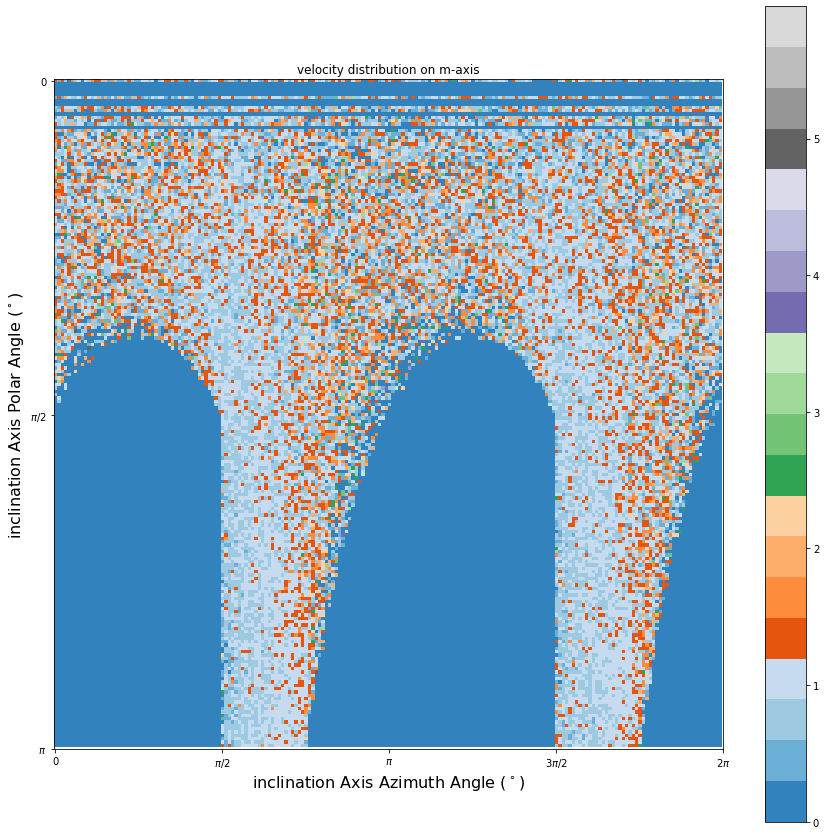

In [6]:
    # All in 1 figrue
    inclination_axis_1Dlist_remove_0step = []
    velocity_1Dlist_remove_0step = []
    for i in range(1,len(GB_list_velocity_list)): 
        inclination_axis_1Dlist_remove_0step.extend(GB_list_inclination_list[i])
        velocity_1Dlist_remove_0step.extend(GB_list_velocity_list[i])
        
    
    bin_num = 200
    inclination_axis_matrix = np.zeros((bin_num,bin_num))
    velocity_bin = np.zeros((bin_num,bin_num))
    
    for i in range(len(inclination_axis_1Dlist_remove_0step)):
        
        i_polar_angle,i_azimuth_angle = inclination_axis_1Dlist_remove_0step[i]
        # Make sure inclination polar angle is between [0, pi/2] and calculate the distribution
        if i_polar_angle > np.pi/2: i_polar_angle = np.pi - i_polar_angle
        inclination_polar_angle_index = int(i_polar_angle//(np.pi/bin_num/2)) # get polar angle index to check the angle distribution
        # Calculate the azimuth angle distribution
        if i_azimuth_angle < 0 or i_azimuth_angle > 2*np.pi: print("The inclinaiton azimuth angle is wrong, please double check.")
        inclination_azimuth_angle_index = int(i_azimuth_angle//(2*np.pi/bin_num)) # get azimuth angle index to check the angle distribution
        # Calculate num distribution and velocity distribution
        x_index = inclination_polar_angle_index
        y_index = inclination_azimuth_angle_index
        if inclination_polar_angle_index == bin_num: x_index = x_index - 1
        if inclination_azimuth_angle_index == bin_num: y_index = y_index - 1
        inclination_axis_matrix[x_index, y_index] += 1 # num distribution matrix
        velocity_bin[x_index,y_index] += velocity_1Dlist_remove_0step[i]
    
    for i in range(bin_num):
        for j in range(bin_num):
            if inclination_axis_matrix[i,j]>0: velocity_bin[i,j] = velocity_bin[i,j]/inclination_axis_matrix[i,j]
                        
    
    # plot matrix figure for inclination axis distribution
    X, Y = np.meshgrid(np.arange(bin_num),np.arange(bin_num))
    plt.figure()
    fig = plt.figure(figsize=(15, 15))
    plt.imshow(velocity_bin,cmap='tab20c')#,vmin=0,vmax=np.max(inclination_axis_matrix_norm_list))
    # plt.contourf(X, Y, velocity_bin, 5,cmap='viridis_r')
    plt.xlabel(r"inclination Axis Azimuth Angle ($^\circ$)", fontsize=16)
    plt.ylabel(r"inclination Axis Polar Angle ($^\circ$)", fontsize=16)
    plt.xticks(np.linspace(0,bin_num,5), ['0',r'$\pi/2$',r'$\pi$',r'3$\pi$/2',r'2$\pi$'])
    plt.yticks(np.linspace(0,bin_num,3), ['0',r'$\pi/2$',r'$\pi$'])
    plt.title(f"velocity distribution on m-axis")
    # plt.axis("off")
    plt.colorbar()
